In [ ]:

!pip install "tensorflow-text>=2.10"
!pip install einops

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
# Download the file
import pathlib
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/MyDrive/data/ret
path_to_file = "merg.txt"

Mounted at /content/drive/
/content/drive/MyDrive/ret


In [ ]:
def data_loader(f_name):
    target = []
    context = []
    with open(f_name, 'r', encoding='utf-8') as f:
        for line in f:
            trg, cnt = line.strip().split('#')
            target.append(trg)
            context.append(cnt)
    return np.array(target), np.array(context)

In [ ]:
context_raw, target_raw = data_loader(path_to_file)
print("Length of the dataset: ", len(context_raw))
print("Sample sentece on line 800:", context_raw[800])
print("Sample transcription on line 800:", target_raw[800])


Length of the dataset:  2030
Sample sentece on line 800: Reformist candidate Mohammad-Ali Najafi is unanimously elected Mayor of Tehran by the city council, ending the 12-year tenure of Principlist Mohammad-Bagher Ghalibaf.
Sample transcription on line 800: Xumuramuu bara hojii wagga 12 ''Seera-jabeessaa' Muhaammad Baghii Galibaaf ilaalchisuun Kaadhimamaan abbaa ilaalcha haaromsaa Mohammad Ali Najaafiin kantiibaa Tehraan haaraa ta'uun mana maree magaalichaatiin sagalee guutudhaan muudaman.


In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Out of the three hospitals, the referral hospital under construction in Gnignag has been completed only 75 percent of its construction phase so far according to the head of the regional health bureau, Oman Amelu (MDr.)'
 b'Flooding in Thailand reaches the residence of the Prime Minister Yingluck Shinawatra in Bangkok, forcing her to withdraw from the Hawaii APEC summit to deal with the crisis.'
 b'British Prime Minister David Cameron announces plans for every household in the UK to automatically have pornography blocked by their internet service provider, unless they choose otherwise.'
 b'A bronze statue of Sir Alex Ferguson, a most successful manager in Manchester United\xe2\x80\x99s history, was unveiled outside Old Trafford.'
 b'Letesenbet Gidey of Ethiopia smashed the world half marathon record with 1:02:52 at Valencia half-marathon, an average of 2:59 min/km!'], shape=(5,), dtype=string)

tf.Tensor(
[b"Akka hogganaa biiroo eegumsa fayyaa naannichaa, Omaan Amelu (MDr.

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and selected punctuation.
  text = tf.strings.regex_replace(text, "[^ a-z.?!,']", '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['', text, ''], separator=' ')
  return text

In [ ]:
example_text = example_context_strings[0]

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Out of the three hospitals, the referral hospital under construction in Gnignag has been completed only 75 percent of its construction phase so far according to the head of the regional health bureau, Oman Amelu (MDr.)
 out of the three hospitals ,  the referral hospital under construction in gnignag has been completed only  percent of its construction phase so far according to the head of the regional health bureau ,  oman amelu mdr . 


In [ ]:
max_vocab_size = 30000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', '.', ',', 'of', 'in', 'to', 'and', 'a']

In [ ]:
print("Length of vocabulary of English:", len(context_text_processor.get_vocabulary()))

Length of vocabulary of English: 7845


In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', ',', 'fi', 'akka', 'keessatti', 'kan', 'irratti', 'yeroo']

In [ ]:
print("Length of vocabulary of Afaan Oromoo:", len(target_text_processor.get_vocabulary()))

Length of vocabulary of Afaan Oromoo: 10745


In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[93, 5, 2, 72, 2824, 4, 2, 4493, 310, 127, 956, 6, 6074, 16, 34, 815, 379,
  175, 5, 31, 956, 1341, 212, 567, 55, 7, 2, 179, 5, 2, 96, 46, 688, 4,
  4943, 7673, 5291, 3]                                                     ,
 [443, 6, 719, 1313, 2, 4426, 5, 2, 71, 40, 3391, 2375, 6, 7432, 4, 6211,
  121, 7, 2164, 18, 2, 5953, 7615, 852, 7, 447, 14, 2, 509, 3]           ,
 [293, 71, 40, 673, 3193, 76, 374, 10, 663, 5879, 6, 2, 599, 7, 7483, 29,
  4737, 7332, 17, 49, 913, 166, 2491, 4, 2214, 80, 3151, 4902, 3]        ]>

In [ ]:

example_tokens[0]

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([  93,    5,    2,   72, 2824,    4,    2, 4493,  310,  127,  956,
          6, 6074,   16,   34,  815,  379,  175,    5,   31,  956, 1341,
        212,  567,   55,    7,    2,  179,    5,    2,   96,   46,  688,
          4, 4943, 7673, 5291,    3])>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)
     

'out of the three hospitals , the referral hospital under construction in gnignag has been completed only percent of its construction phase so far according to the head of the regional health bureau , oman amelu mdr .'

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[   9  199 1424  686    8  219 4866   12   94    6]

[ 2442  3133  4136   665 10543  2177  3615   943  1767     3]
[ 3133  4136   665 10543  2177  3615   943  1767     3  2180]


In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 53)
Encoder output, shape (batch, s, units): (64, 53, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 53, 256)
Target sequence, shape (batch, t, units): (64, 45, 256)
Attention result, shape (batch, t, units): (64, 45, 256)
Attention weights, shape (batch, t, s):    (64, 45, 53)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1).round()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

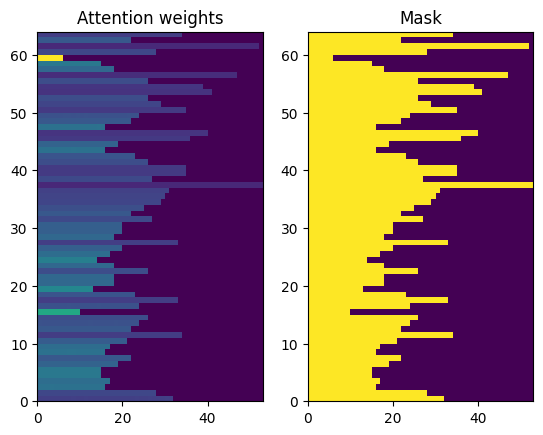

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('')
    self.end_token = self.word_to_id('')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')
     

encoder output shape: (batch, s, units) (64, 53, 256)
input target tokens shape: (batch, t) (64, 45)
logits shape shape: (batch, target_vocabulary_size) (64, 45, 10745)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]
     

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\ *', '')
  result = tf.strings.regex_replace(result, ' *\<\/s\> *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [ ]:

# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b"baafaman duula hojirra saatalaayitii odola jallisii hawaa'ii onnachiistu shaampiyoonummaatti tegenee",
       b'woorkshooppichi orliins jiraachaa gaazexissitootaaf baniinsa abbay guyyaalamature biootessaa makuuf dorgommiiwwan',
       b"ballessuuf dooniiwwan ajjeechaa moozambiki boowul pilaaneticha 'doon shuumatee haaromsaa qindeessa"],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 53)
Target tokens, shape: (batch, t) (64, 45)
logits, shape: (batch, t, target_vocabulary_size) (64, 45, 10745)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.282196, 'expected_acc': 9.306654257794323e-05}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

 7/20 [=========>....................] - ETA: 18s - loss: 9.2809 - masked_acc: 0.0000e+00 - masked_loss: 9.2810

20/20 [==============================] - 20s 480ms/step - loss: 9.2809 - masked_acc: 0.0000e+00 - masked_loss: 9.2810


{'loss': 9.280855178833008,
 'masked_acc': 0.0,
 'masked_loss': 9.280975341796875}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 2,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
    )

Epoch 1/10
100/100 [==============================] - 351s 3s/step - loss: 7.9089 - masked_acc: 0.0621 - masked_loss: 7.9154 - val_loss: 8.2520 - val_masked_acc: 0.0686 - val_masked_loss: 8.2520
Epoch 2/10
100/100 [==============================] - 314s 3s/step - loss: 6.0861 - masked_acc: 0.1774 - masked_loss: 6.0992 - val_loss: 8.0177 - val_masked_acc: 0.1004 - val_masked_loss: 8.0177
Epoch 3/10
100/100 [==============================] - 321s 3s/step - loss: 2.7011 - masked_acc: 0.5762 - masked_loss: 2.7218 - val_loss: 8.4360 - val_masked_acc: 0.0968 - val_masked_loss: 8.4360
Epoch 4/10
100/100 [==============================] - 313s 3s/step - loss: 0.6726 - masked_acc: 0.9215 - masked_loss: 0.6763 - val_loss: 9.3666 - val_masked_acc: 0.0802 - val_masked_loss: 9.3666
Epoch 5/10
100/100 [==============================] - 318s 3s/step - loss: 0.1615 - masked_acc: 0.9911 - masked_loss: 0.1631 - val_loss: 9.9165 - val_masked_acc: 0.0813 - val_masked_loss: 9.9165
Epoch 6/10
100/100 [=====

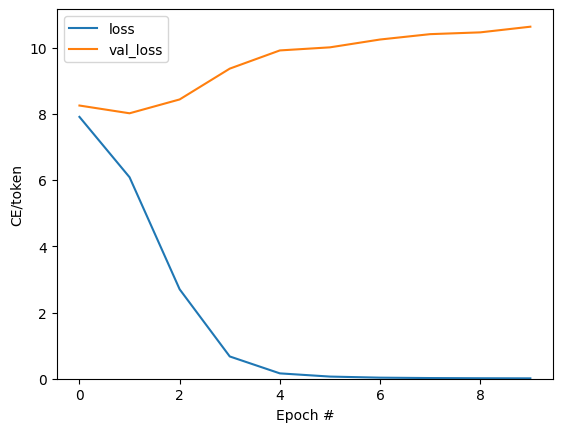

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

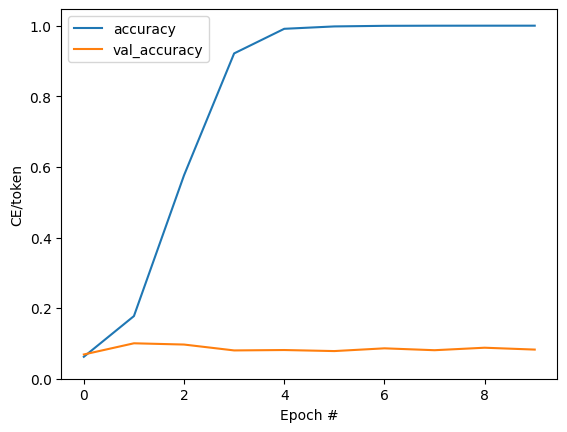

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  result = tf.strings.regex_replace(result, r' ([.?!]) ', r'\1')
  return result

In [ ]:
result = model.translate(['Thanks.']) # Galatoomaa.
result = result[0].numpy().decode()
result

"galaanaa dhuguun wanta danda'amuuf keessumaa galatni isa ashaboon fayyadama tekinooloojiitiin bishaan irra adda ba'uuf haa ta'u malee akeekkachiisi lixa sumaatiraa keessatti akkuma kana kirkirri lafa ni mudata jedhu qabatamaa akka hin taane mirkanaa'e.. tahan yeroo.adda addummaa wal bira yoo.yeroo jirtutti , akka warri rooman"

In [ ]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [ ]:
long_text = context_raw[-1]
import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 Dorgommiileen ispoortii adda addaa, agarsiisonni fi
simpooziyemiiwwanis qophiilee festivaalicha irratti karoorfamaniidha.


In [ ]:
long_text = "The best way to learn English is to go to America."
import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap("Afaan Ingilizii barachuuf karaan hundarra gaariin gara Ameerikaa deemuudha.")))

Expected output:
 Afaan Ingilizii barachuuf karaan hundarra gaariin gara Ameerikaa
deemuudha.


In [ ]:
inputs = [
    "It is really cold here.", # "As baayyee qorra."
    "This is my life.", # "Kun jireenya kooti."
    "His room is a mess." # "Kutaan isaa jeequmsa."
]

In [ ]:

%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

swiidin bara ruwandaa keessatti yakka duguggaa sanyii keessatti hirmattaniitu himannaa jedhuun manguddoo umurii lammii siwidiin dhalootaan ruwaandaa kan ta'an klaaver beerinkindii hidha umurii guutuun adabe.. meeshaan uffata miiccaa samsang ariitii guddaan uffata ulfaataa miicaa yoo jiraate dhuka'uu akka danda'u akeekkachiise.. doonaald tiraamp qophii champiyoonaa suupper boowul
guddaan itoophiyaa marsaa lamatti adda bahe.bakka bu'oota ummataa haaraan kun galii magaalichaa sektera kanaa nii guddisa jedhe.kun waggaa darbe mirkaneesse.baaraak obaamaan ammoo akka jiru akeeka jedhe.irraa bilisa akka waancaa biyyootaa afirikaacaf darbeera.. km sirrii fi galaanaa irraa faana , irratti
keessatti akkuma bashannanaa fudhachuun gara waan ijaan mullatuutti guddachaa dhufeen., aangawoota filaman garagaraa dabalatee., filannoo kantiibaa magaalaa niwu yoork bara waliin dhahuuf yaaluun yakka waliin dhahuun shakkamanii hidhaman.naannoo daangaa somaaliyaatti ni deemu kan kun tahan gara dorgomii ni deeb

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()


swiidin bara ruwandaa keessatti yakka duguggaa sanyii keessatti hirmattaniitu himannaa jedhuun manguddoo umurii lammii siwidiin dhalootaan ruwaandaa kan ta'an klaaver beerinkindii hidha umurii guutuun adabe.. meeshaan uffata miiccaa samsang ariitii guddaan uffata ulfaataa miicaa yoo jiraate dhuka'uu akka danda'u akeekkachiise.. doonaald tiraamp qophii champiyoonaa suupper boowul
guddaan itoophiyaa marsaa lamatti adda bahe.bakka bu'oota ummataa haaraan kun galii magaalichaa sektera kanaa nii guddisa jedhe.kun waggaa darbe mirkaneesse.baaraak obaamaan ammoo akka jiru akeeka jedhe.irraa bilisa akka waancaa biyyootaa afirikaacaf darbeera.. km sirrii fi galaanaa irraa faana , irratti
keessatti akkuma bashannanaa fudhachuun gara waan ijaan mullatuutti guddachaa dhufeen., aangawoota filaman garagaraa dabalatee., filannoo kantiibaa magaalaa niwu yoork bara waliin dhahuuf yaaluun yakka waliin dhahuun shakkamanii hidhaman.naannoo daangaa somaaliyaatti ni deemu kan kun tahan gara dorgomii ni deeb

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 19s, sys: 1.24 s, total: 1min 20s
Wall time: 1min 20s


In [ ]:

%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

swiidin bara ruwandaa keessatti yakka duguggaa sanyii keessatti hirmattaniitu himannaa jedhuun manguddoo umurii lammii siwidiin dhalootaan ruwaandaa kan ta'an klaaver beerinkindii hidha umurii guutuun adabe.. meeshaan uffata miiccaa samsang ariitii guddaan uffata ulfaataa miicaa yoo jiraate dhuka'uu akka danda'u akeekkachiise.. doonaald tiraamp qophii champiyoonaa suupper boowul
guddaan itoophiyaa marsaa lamatti adda bahe.bakka bu'oota ummataa haaraan kun galii magaalichaa sektera kanaa nii guddisa jedhe.kun waggaa darbe mirkaneesse.baaraak obaamaan ammoo akka jiru akeeka jedhe.irraa bilisa akka waancaa biyyootaa afirikaacaf darbeera.. km sirrii fi galaanaa irraa faana , irratti
keessatti akkuma bashannanaa fudhachuun gara waan ijaan mullatuutti guddachaa dhufeen., aangawoota filaman garagaraa dabalatee., filannoo kantiibaa magaalaa niwu yoork bara waliin dhahuuf yaaluun yakka waliin dhahuun shakkamanii hidhaman.naannoo daangaa somaaliyaatti ni deemu kan kun tahan gara dorgomii ni deeb

In [ ]:

%%time
tf.saved_model.save(export, 'eng_translator_newest',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 49s, sys: 2.47 s, total: 1min 52s
Wall time: 1min 53s


In [ ]:
%%time
reloaded = tf.saved_model.load('eng_translator_newest')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 1min 12s, sys: 1.92 s, total: 1min 14s
Wall time: 1min 13s


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

def compute_bleu_score(references, translations, weights=(0.25, 0.25, 0.25, 0.25)):
    """
    Compute the BLEU score for a set of translations and their corresponding reference translations.
    :param references: A list of reference translations, where each translation is a list of tokens.
    :param translations: A list of translations to evaluate, where each translation is a list of tokens.
    :param weights: A tuple of weights to use for each n-gram score, where len(weights) = max_n in the n-gram scores.
    :return: The BLEU score for the translations, as a float between 0 and 1.
    """
    # Use smoothing to avoid division by zero
    smoothing_function = SmoothingFunction().method1

    # Compute the BLEU score for the translations and their reference translations
    bleu_score = corpus_bleu([[ref] for ref in references], translations, weights=weights, smoothing_function=smoothing_function)

    return bleu_score

In [ ]:
result = reloaded.translate(tf.constant(context_raw[100:200]))

In [ ]:
import re
result = [x.numpy().decode() for x in result]
pattern = r"(?<=[.?!])\s+"
result = [re.sub(pattern, "", x) for x in result]

In [ ]:
# Compute the BLEU score for the translations and their reference translations
bleu_score = compute_bleu_score(target_raw[100:200], result)

print("BLEU score:", bleu_score)

In [ ]:
result[:10]

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

In [ ]:
result = reloaded.translate(["do you come today?"]) #Har'a ni dhufta?
print(result[0].numpy().decode())